### a) Example for implementing SubPixel Super-Resoltuion network (based on official tutorial from keras.io - https://keras.io/examples/vision/super_resolution_sub_pixel/) and 
### b) Checking the quality of the generated images by PSNR, SSIM, DISTS and BRISQUE metrics via 'piq' IQA framework (https://github.com/photosynthesis-team/piq).

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
!pip install piq

     |████████████████████████████████| 127 kB 5.2 MB/s 


In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70778880/70763455 [==============================] - 24s 0us/step


In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

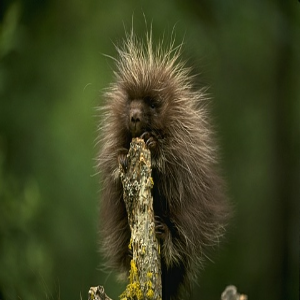

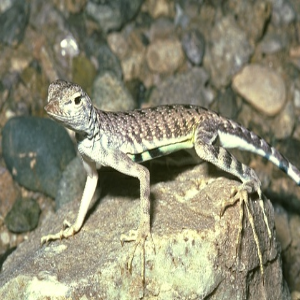

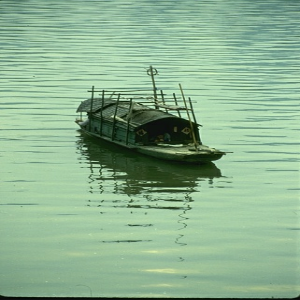

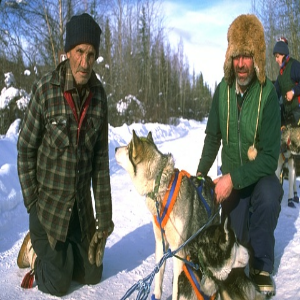

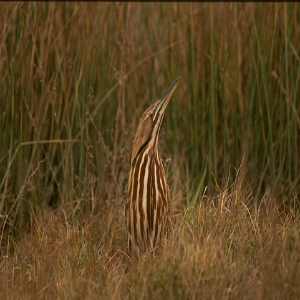

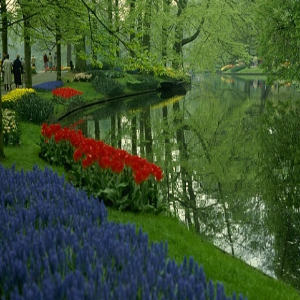

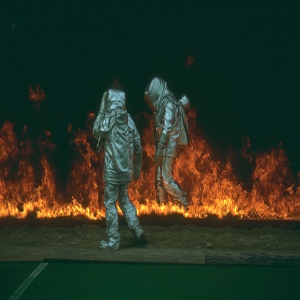

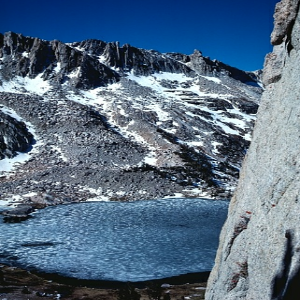

In [ ]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

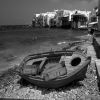

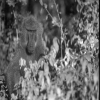

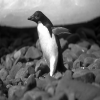

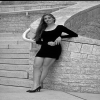

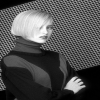

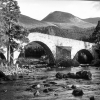

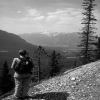

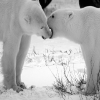

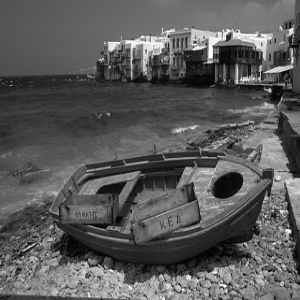

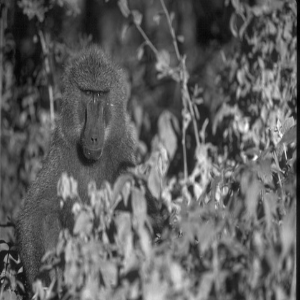

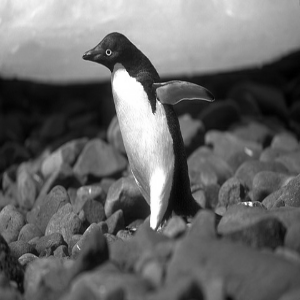

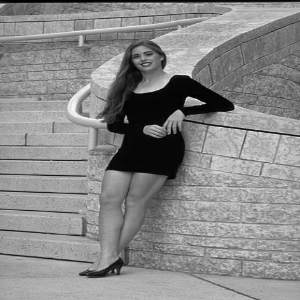

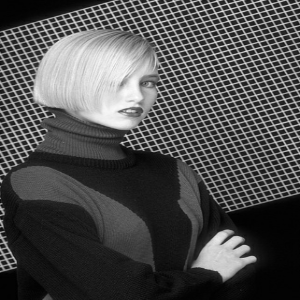

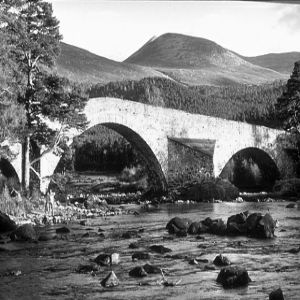

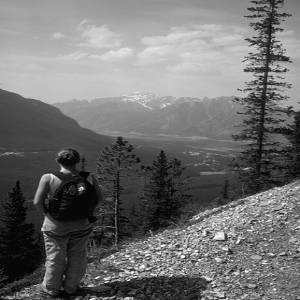

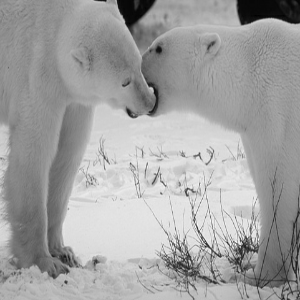

In [ ]:
# take a look at the input and target data.

for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [ ]:
# Define the model

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
# callbacks and checkpoints

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

Epoch 1/100
Mean PSNR for epoch: 21.06


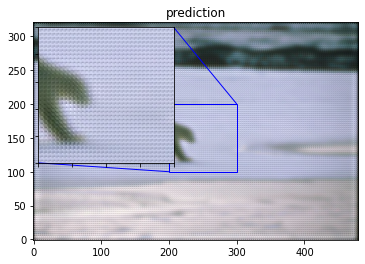

50/50 - 18s - loss: 0.0487 - val_loss: 0.0079 - 18s/epoch - 362ms/step
Epoch 2/100
Mean PSNR for epoch: 24.28
50/50 - 4s - loss: 0.0055 - val_loss: 0.0036 - 4s/epoch - 89ms/step
Epoch 3/100
Mean PSNR for epoch: 25.48
50/50 - 4s - loss: 0.0036 - val_loss: 0.0030 - 4s/epoch - 82ms/step
Epoch 4/100
Mean PSNR for epoch: 26.33
50/50 - 5s - loss: 0.0031 - val_loss: 0.0026 - 5s/epoch - 94ms/step
Epoch 5/100
Mean PSNR for epoch: 25.92
50/50 - 3s - loss: 0.0029 - val_loss: 0.0026 - 3s/epoch - 62ms/step
Epoch 6/100
Mean PSNR for epoch: 26.29
50/50 - 3s - loss: 0.0028 - val_loss: 0.0025 - 3s/epoch - 54ms/step
Epoch 7/100
Mean PSNR for epoch: 26.29
50/50 - 2s - loss: 0.0029 - val_loss: 0.0025 - 2s/epoch - 49ms/step
Epoch 8/100
Mean PSNR for epoch: 26.31
50/50 - 3s - loss: 0.0028 - val_loss: 0.0024 - 3s/epoch - 54ms/step
Epoch 9/100
Mean PSNR for epoch: 26.45
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024 - 2s/epoch - 50ms/step
Epoch 10/100
Mean PSNR for epoch: 26.06
50/50 - 3s - loss: 0.0027 - val_l

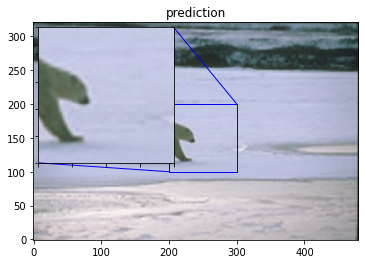

50/50 - 4s - loss: 0.0027 - val_loss: 0.0024 - 4s/epoch - 72ms/step
Epoch 22/100
Mean PSNR for epoch: 26.27
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 51ms/step
Epoch 23/100
Mean PSNR for epoch: 26.66
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 24/100
Mean PSNR for epoch: 26.73
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 50ms/step
Epoch 25/100
Mean PSNR for epoch: 27.08
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 50ms/step
Epoch 26/100
Mean PSNR for epoch: 26.37
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 27/100
Mean PSNR for epoch: 27.25
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 28/100
Mean PSNR for epoch: 26.54
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 62ms/step
Epoch 29/100
Mean PSNR for epoch: 26.60
50/50 - 4s - loss: 0.0026 - val_loss: 0.0023 - 4s/epoch - 81ms/step
Epoch 30/100
Mean PSNR for epoch: 26.45
50/50 - 2s - loss: 0.0026 - 

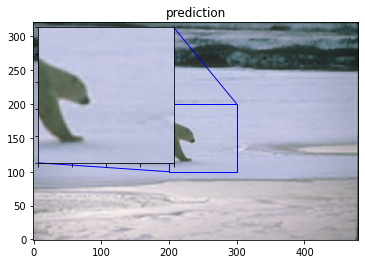

50/50 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 68ms/step
Epoch 42/100
Mean PSNR for epoch: 26.74
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 43/100
Mean PSNR for epoch: 26.58
50/50 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 54ms/step
Epoch 44/100
Mean PSNR for epoch: 26.87
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 45/100
Mean PSNR for epoch: 26.48
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 53ms/step
Epoch 46/100
Mean PSNR for epoch: 26.27
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 50ms/step
Epoch 47/100
Mean PSNR for epoch: 26.59
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 48/100
Mean PSNR for epoch: 26.26
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 49/100
Mean PSNR for epoch: 25.54
50/50 - 3s - loss: 0.0032 - val_loss: 0.0029 - 3s/epoch - 50ms/step
Epoch 50/100
Mean PSNR for epoch: 26.40
50/50 - 2s - loss: 0.0027 - 

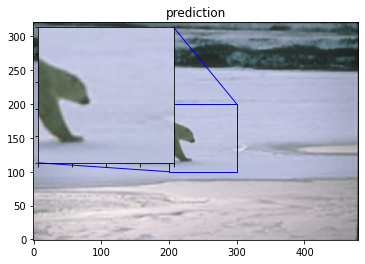

50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 69ms/step
Epoch 62/100
Mean PSNR for epoch: 26.29
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 63/100
Mean PSNR for epoch: 26.39
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 50ms/step
Epoch 64/100
Mean PSNR for epoch: 27.35
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 50ms/step
Epoch 65/100
Mean PSNR for epoch: 26.90
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 66/100
Mean PSNR for epoch: 26.43
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 51ms/step
Epoch 67/100
Mean PSNR for epoch: 26.61
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 50ms/step
Epoch 68/100
Mean PSNR for epoch: 26.68
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 69/100
Mean PSNR for epoch: 26.45
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 70/100
Mean PSNR for epoch: 26.73
50/50 - 2s - loss: 0.0025 - 

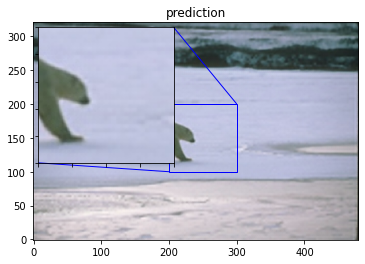

50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 68ms/step
Epoch 82/100
Mean PSNR for epoch: 26.67
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 50ms/step
Epoch 83/100
Mean PSNR for epoch: 26.88
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 84/100
Mean PSNR for epoch: 26.71
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 85/100
Mean PSNR for epoch: 26.86
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 86/100
Mean PSNR for epoch: 26.20
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 50ms/step
Epoch 87/100
Mean PSNR for epoch: 26.53
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 50ms/step
Epoch 88/100
Mean PSNR for epoch: 26.43
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 50ms/step
Epoch 89/100
Mean PSNR for epoch: 26.61
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022 - 3s/epoch - 54ms/step
Epoch 90/100
Mean PSNR for epoch: 26.39
50/50 - 2s - loss: 0.0025 - 

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [ ]:
import torch
from piq import BRISQUELoss, DISTS, ssim, psnr

brisque = BRISQUELoss(data_range=1.)
DISTS = DISTS()

Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.1/dists_weights.pt" to /root/.cache/torch/hub/checkpoints/dists_weights.pt
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


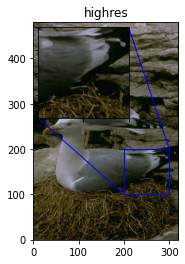

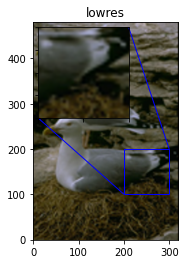

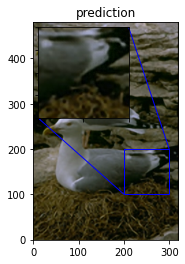


PSNR low_res 26.70099639892578
PSNR prediction 27.237213134765625

SSIM low_res  0.7147008776664734
SSIM prediction  0.7520685791969299

BRISQUE Low_res  57.75653076171875
BRISQUE prediction 52.79949951171875
BRISQUE highres 50.32635498046875

DISTS low_res  0.18131136894226074
DISTS prediction  0.14899766445159912


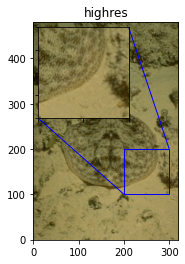

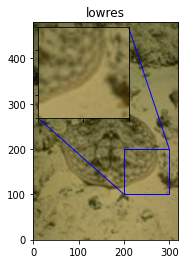

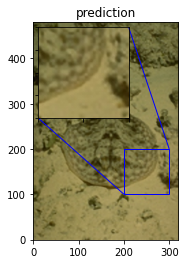


PSNR low_res 30.494136810302734
PSNR prediction 30.393112182617188

SSIM low_res  0.7909411787986755
SSIM prediction  0.8162142634391785

BRISQUE Low_res  52.28582763671875
BRISQUE prediction 52.50311279296875
BRISQUE highres 34.43280029296875

DISTS low_res  0.20153546333312988
DISTS prediction  0.1805015206336975


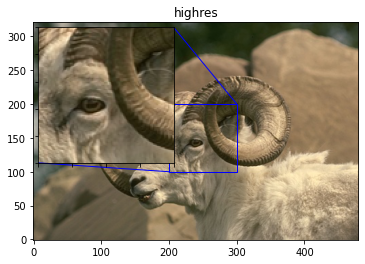

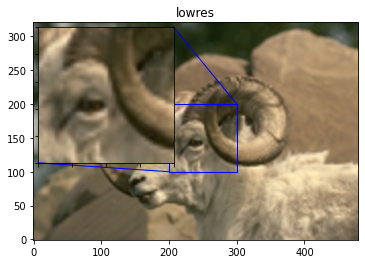

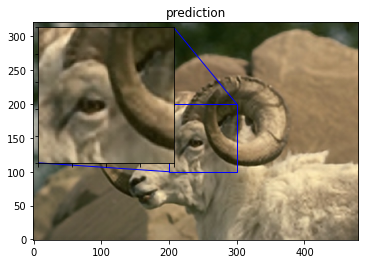


PSNR low_res 31.300031661987305
PSNR prediction 31.124021530151367

SSIM low_res  0.8803941607475281
SSIM prediction  0.8915101885795593

BRISQUE Low_res  53.19744873046875
BRISQUE prediction 37.79412841796875
BRISQUE highres 28.06512451171875

DISTS low_res  0.1497807502746582
DISTS prediction  0.12156867980957031


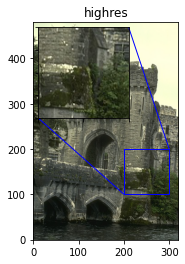

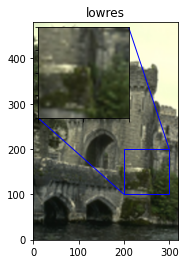

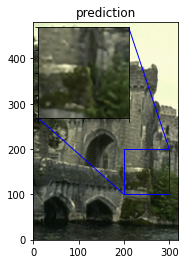


PSNR low_res 24.053773880004883
PSNR prediction 24.45988655090332

SSIM low_res  0.6474247574806213
SSIM prediction  0.6863741874694824

BRISQUE Low_res  54.94207763671875
BRISQUE prediction 58.79705810546875
BRISQUE highres 60.13690185546875

DISTS low_res  0.2033177614212036
DISTS prediction  0.17465531826019287


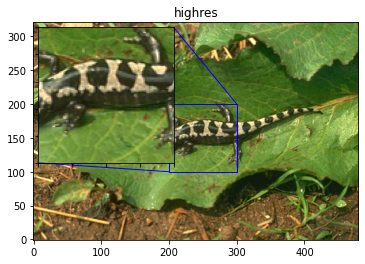

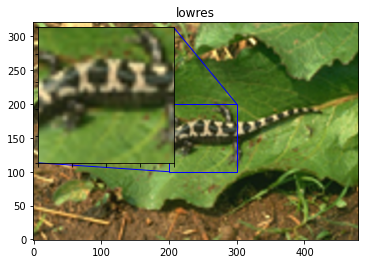

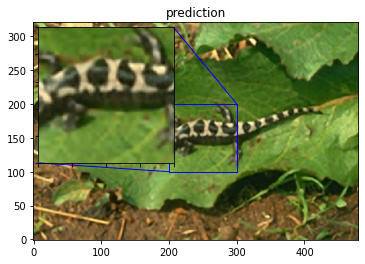


PSNR low_res 25.07404136657715
PSNR prediction 25.773372650146484

SSIM low_res  0.6873523592948914
SSIM prediction  0.7323284149169922

BRISQUE Low_res  53.85174560546875
BRISQUE prediction 50.98797607421875
BRISQUE highres 40.07342529296875

DISTS low_res  0.20004236698150635
DISTS prediction  0.1847183108329773


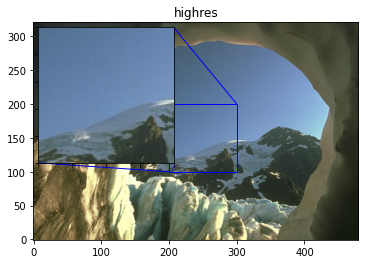

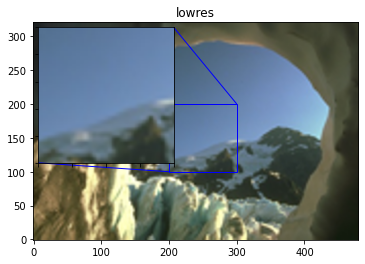

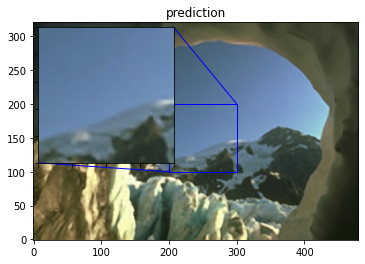


PSNR low_res 28.170059204101562
PSNR prediction 28.981122970581055

SSIM low_res  0.8697316646575928
SSIM prediction  0.888613224029541

BRISQUE Low_res  61.17303466796875
BRISQUE prediction 39.32830810546875
BRISQUE highres 27.73553466796875

DISTS low_res  0.17700815200805664
DISTS prediction  0.15386474132537842


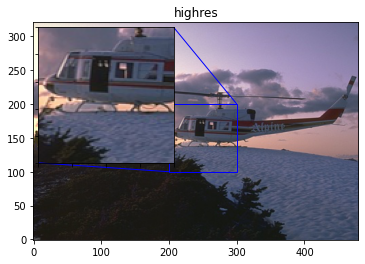

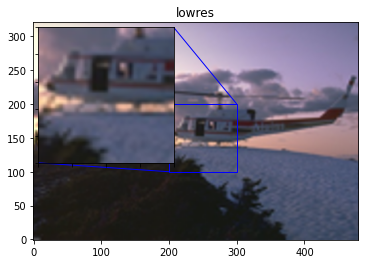

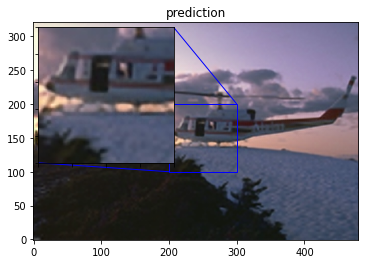


PSNR low_res 29.374143600463867
PSNR prediction 29.99640464782715

SSIM low_res  0.8611342906951904
SSIM prediction  0.8757025599479675

BRISQUE Low_res  62.61151123046875
BRISQUE prediction 53.04949951171875
BRISQUE highres 38.65447998046875

DISTS low_res  0.21245968341827393
DISTS prediction  0.17702728509902954


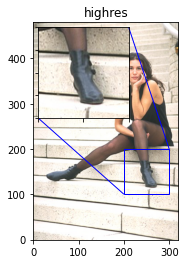

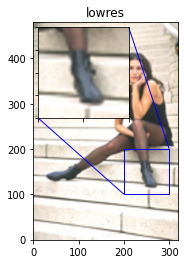

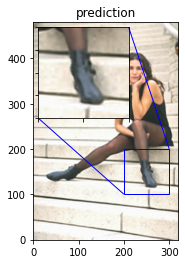


PSNR low_res 24.778757095336914
PSNR prediction 27.00788116455078

SSIM low_res  0.790178120136261
SSIM prediction  0.8297364115715027

BRISQUE Low_res  63.78045654296875
BRISQUE prediction 61.56268310546875
BRISQUE highres 55.71063232421875

DISTS low_res  0.18703538179397583
DISTS prediction  0.15004503726959229


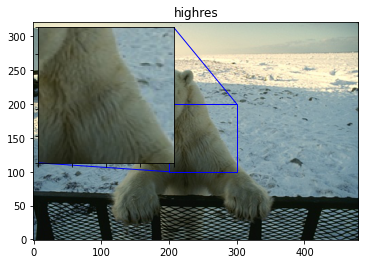

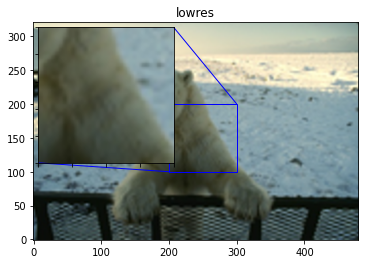

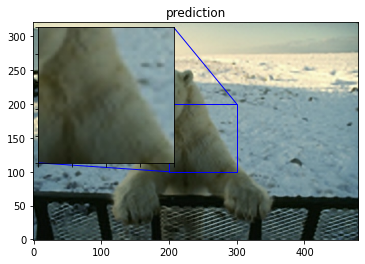


PSNR low_res 23.568498611450195
PSNR prediction 23.434375762939453

SSIM low_res  0.7204015851020813
SSIM prediction  0.7471063137054443

BRISQUE Low_res  65.50946044921875
BRISQUE prediction 56.90350341796875
BRISQUE highres 40.57830810546875

DISTS low_res  0.1733337640762329
DISTS prediction  0.13346588611602783


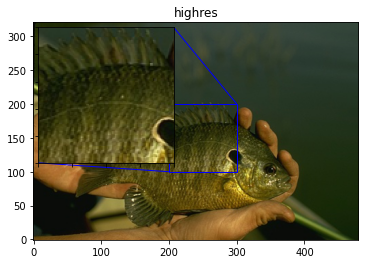

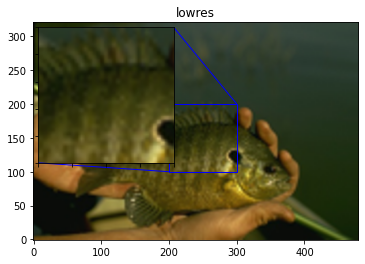

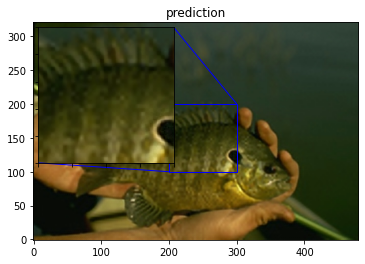


PSNR low_res 31.02329444885254
PSNR prediction 31.182308197021484

SSIM low_res  0.873519241809845
SSIM prediction  0.8793848156929016

BRISQUE Low_res  51.62957763671875
BRISQUE prediction 35.77508544921875
BRISQUE highres 33.47186279296875

DISTS low_res  0.15391749143600464
DISTS prediction  0.1260797381401062
--------------------------------------------------
Summary: 

Avg. PSNR of lowres images is 27.4538
Avg. PSNR of reconstructions is 27.9590
Avg. SSIM of lowres images is 0.7836
Avg. SSIM of reconstructions is 0.8099
Avg. BRISQUE of lowres images is 57.6738
Avg. BRISQUE of highres images is 40.9185
Avg. BRISQUE of reconstructions is 49.9501
Avg. DISTS of lowres images is 0.1840
Avg. DISTS of reconstructions is 0.1551


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
total_bicubic_ssim = 0.0
total_test_ssim = 0.0
total_bicubic_brisque = 0.0
total_test_brisque = 0.0
total_highres_brisque = 0.0
total_bicubic_dists = 0.0
total_test_dists = 0.0

n=10

for index, test_img_path in enumerate(test_img_paths[60:int(60+n)]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor

    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))

    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)

    torch_lr = torch.tensor(lowres_img_arr).permute(2,0,1)[None, :,:,:]/255.
    torch_hr = torch.tensor(highres_img_arr).permute(2,0,1)[None, :,:,:]/255.
    torch_predict = torch.tensor(predict_img_arr).permute(2,0,1)[None, :,:,:]/255.

    bicubic_psnr =psnr(torch_lr, torch_hr).item()
    test_psnr = psnr(torch_predict, torch_hr).item()
    
    bicubic_ssim = ssim(torch_lr, torch_hr).item()
    test_ssim = ssim(torch_predict, torch_hr).item()

    bicubic_brisque = brisque(torch.tensor(lowres_img_arr).permute(2,0,1)[None, :,:,:]/255.).item()
    highres_brisque = brisque(torch.tensor(highres_img_arr).permute(2,0,1)[None, :,:,:]/255.).item()
    test_brisque = brisque(torch.tensor(predict_img_arr).permute(2,0,1)[None, :,:,:]/255.).item()

    bicubic_dists = DISTS(torch_lr, torch_hr).item()
    test_dists = DISTS(torch_predict, torch_hr).item()

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    total_bicubic_ssim += bicubic_ssim
    total_test_ssim += test_ssim

    total_bicubic_brisque += bicubic_brisque
    total_test_brisque += test_brisque
    total_highres_brisque += highres_brisque

    total_bicubic_dists += bicubic_dists
    total_test_dists += test_dists


    plot_results(highres_img, index, "highres")
    plot_results(lowres_img, index, "lowres")
    plot_results(prediction, index, "prediction")


    print("\nPSNR low_res" , bicubic_psnr)
    print("PSNR prediction" , test_psnr)

    print("\nSSIM low_res ", bicubic_ssim)
    print("SSIM prediction ", test_ssim)

    print("\nBRISQUE Low_res ", bicubic_brisque)
    print("BRISQUE prediction", test_brisque)
    print("BRISQUE highres" , highres_brisque)

    print("\nDISTS low_res ", bicubic_dists)
    print("DISTS prediction ", test_dists)

print("-"*50)
print("Summary: ")
print("\nAvg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / n))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / n))
print("Avg. SSIM of lowres images is %.4f" % (total_bicubic_ssim / n))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / n))
print("Avg. BRISQUE of lowres images is %.4f" % (total_bicubic_brisque / n))
print("Avg. BRISQUE of highres images is %.4f" % (total_highres_brisque / n))
print("Avg. BRISQUE of reconstructions is %.4f" % (total_test_brisque / n))
print("Avg. DISTS of lowres images is %.4f" % (total_bicubic_dists / n))
print("Avg. DISTS of reconstructions is %.4f" % (total_test_dists / n))